<a href="https://colab.research.google.com/github/song-pongpanit/Spam-SMS-Detection/blob/main/EDA_sms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import re
from tqdm import trange
! pip install unidecode
from unidecode import unidecode
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Data

In [ ]:
data = pd.read_csv('/content/all_sms.csv', encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5694 entries, 0 to 5693
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ï»¿target  5694 non-null   object
 1   text       5694 non-null   object
dtypes: object(2)
memory usage: 89.1+ KB


In [ ]:
data.rename(columns={"ï»¿target": "target"}, inplace=True)
data['text'] = data['text'].apply(lambda x : re.sub('\.{2,}', '.', x))
data.head()

,target,text
0,ham,"Go until jurong point, crazy. Available only i..."
1,ham,Ok lar. Joking wif u oni.
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor. U c already then say.
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data['target'].value_counts(normalize = True)

ham     0.847383
spam    0.152617
Name: target, dtype: float64

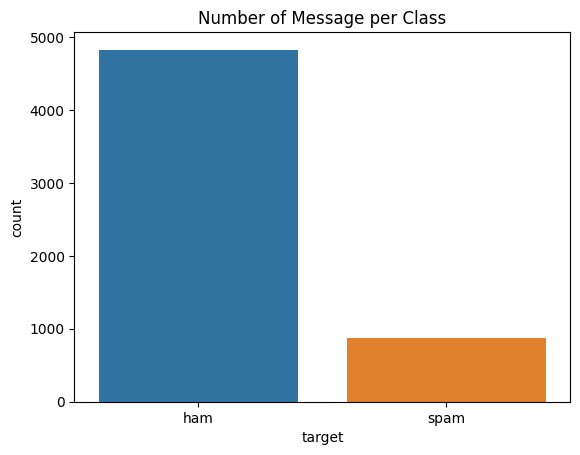

In [ ]:
sns.countplot(data=data ,x='target', hue='target')
plt.title('Number of Message per Class')
plt.show()

# (1.) Duplicate

In [ ]:
data.duplicated(subset='text').value_counts()

False    5284
True      410
dtype: int64

In [ ]:
data.drop_duplicates(subset='text', inplace = True, ignore_index= True)
data.shape

(5284, 2)

# (2.) Len of char

In [ ]:
data['char_len'] = data['text'].str.len()

In [ ]:
data.groupby('target')['char_len'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
ham,4509.0,70.117986,56.172774,2.0,34.0,52.0,90.0,908.0
spam,775.0,132.873548,36.234443,13.0,113.5,146.0,158.0,325.0


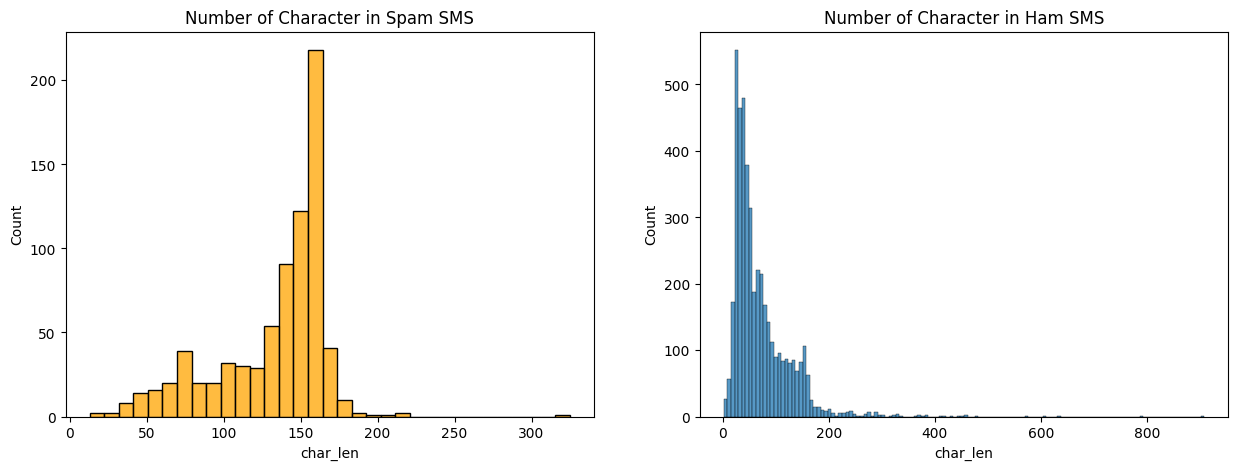

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Number of Character in Spam SMS')
sns.histplot(data=data[data['target']=='spam'], x='char_len', color='orange')
plt.subplot(1,2,2)
plt.title('Number of Character in Ham SMS')
sns.histplot(data=data[data['target']=='ham'], x='char_len')
plt.show()

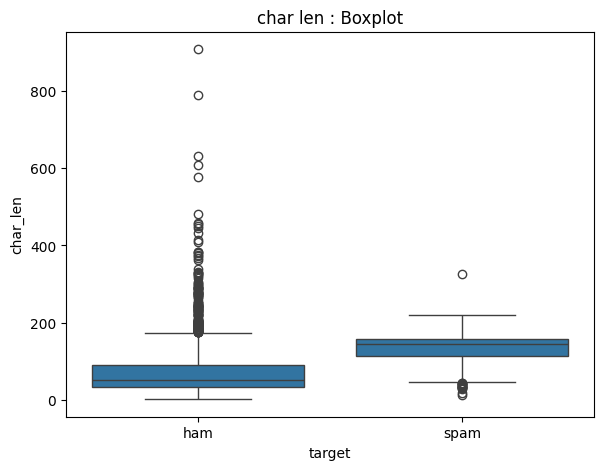

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('char len : Boxplot')
sns.boxplot(data=data, y='char_len', x='target')
plt.show()

# (3.1) count word

In [ ]:
data['word'] = data['text'].apply(lambda x : len(x.split()))
data.head()

,target,text,char_len,word
0,ham,"Go until jurong point, crazy. Available only i...",106,20
1,ham,Ok lar. Joking wif u oni.,25,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor. U c already then say.,45,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


In [ ]:
data.groupby('target')['word'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
ham,4509.0,14.164338,11.124779,1.0,7.0,11.0,18.0,171.0
spam,775.0,22.932903,7.012402,2.0,19.0,25.0,28.0,53.0


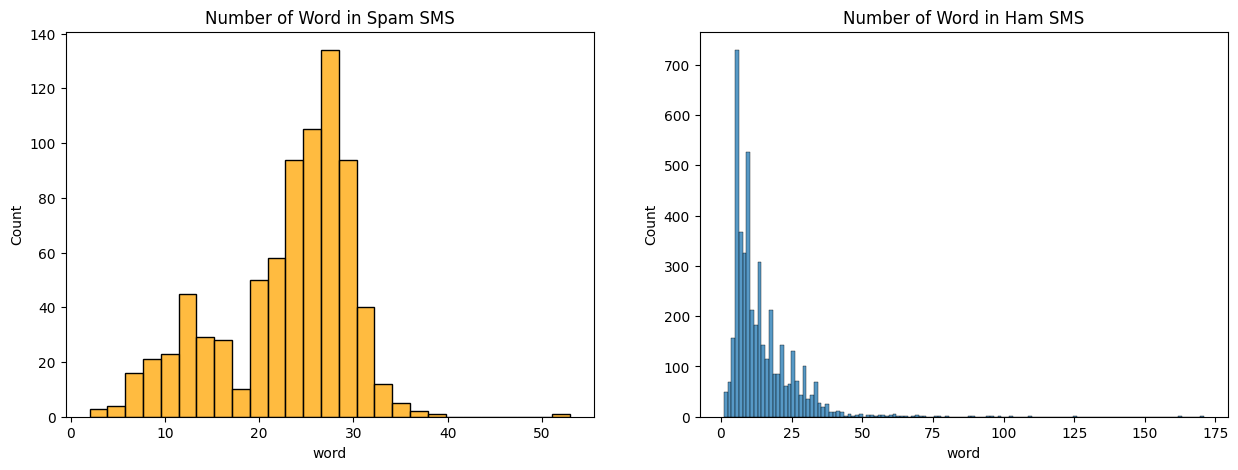

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Number of Word in Spam SMS')
sns.histplot(data=data[data['target']=='spam'], x='word', color='orange')
plt.subplot(1,2,2)
plt.title('Number of Word in Ham SMS')
sns.histplot(data=data[data['target']=='ham'], x='word')
plt.show()

In [ ]:
data[data['word']>= 128]

,target,text,char_len,word
1059,ham,For me the love should start with attraction.i...,908,171
1799,ham,The last thing i ever wanted to do was hurt yo...,790,162


In [ ]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub('txt','text', text)
    text = re.sub('&lt;#&gt;',' ', text)
    text = re.sub('^u\s','you ',text)
    text = re.sub('\su\s',' you ',text)
    text = re.sub('^ur\s','your ',text)
    text = re.sub('\sur\s',' your ',text)
    text = re.sub('\w+(\'m)',' am ', text)
    text = re.sub('i\'m','i am', text)
    text = re.sub('i\'ll','i will', text)
    text = re.sub('i\'ve','i have', text)
    text = re.sub('you\'re','you are', text)
    text = re.sub('(\'s)\s',' is ', text)
    text = re.sub('\s(dun)\s',' do not ', text)
    text = re.sub('\s*(didn\'t)\s',' did not ', text)
    text = re.sub('\s*(don\'t)\s',' do not ', text)
    text = re.sub('\s(c)\s',' see ', text)
    text = re.sub('\s(wkly)\s', ' weekly ', text)
    text = re.sub('[à¹à¸âï]',' ',text)
    text = re.sub('https?://\S+|www\.\S+|cutt\.ly\S+|bit\.ly]\S+', ' ', text)
    text = re.sub('\W+', ' ', text)
    text = re.sub('\sk\s|^k\s|okie|okay|okey', ' ok ', text)
    text = re.sub('\s+',' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
    return text

def lemmatize(words):
    words=nlp(words)
    lemmas = []
    for word in words:
        lemmas.append(word.lemma_)
    return lemmas

def listtostring(s):
    str1=' '
    return (str1.join(s))

def clean_text(input):
    word=preprocess(input)
    lemmas=lemmatize(word)
    return listtostring(lemmas)

nlp=spacy.load('en_core_web_sm')
data['new_text'] = data['text'].apply(clean_text)
data.head(5000)

,target,text,char_len,word,new_text
0,ham,"Go until jurong point, crazy. Available only i...",106,20,go jurong point crazy available bugis n great ...
1,ham,Ok lar. Joking wif u oni.,25,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry weekly comp win fa cup final tkts m...
3,ham,U dun say so early hor. U c already then say.,45,11,say early hor see already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think go usf live around though
...,...,...,...,...,...
4995,ham,How do friends help us in problems? They give ...,147,26,friend help we problem give stupid suggestion ...
4996,ham,I will be gentle baby! Soon you will be taking...,99,18,gentle baby soon take inch deep inside tight p...
4997,ham,NOT MUCH NO FIGHTS. IT WAS A GOOD NITE!!,40,9,much fight good nite
4998,ham,Nt joking seriously i told,26,5,not joke seriously tell


In [ ]:
# test = 'URGENT! U have won a 1 week FREE membership in our à¹à¸100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18'
test = 'Hey, iouri gave me your number, I\'m wylie, ryan\'s friend'
# test = 'Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES'
# test = 'Wen ur lovable bcums angry wid u, dnt take it seriously. Coz being angry is d most childish n true way of showing deep affection, care n luv!. kettoda manda. Have nice day da.'
test = str(test).lower()
test = re.sub('^u\s','you ',test)
test = re.sub('\su\s',' you ',test)
test = re.sub('^ur\s','your ',test)
test = re.sub('\sur\s',' your ',test)
test = re.sub('(\'s)\s',' is ', test)
test = re.sub('[à¹à¸]','',test)
test = re.sub('\W+', ' ', test)
test = re.sub('https?://\S+|www\.\S+|cutt\.ly\S+|bit\.ly]\S+', '', test)
print(test)

hey iouri gave me your number i m wylie ryan is friend


In [ ]:
# data.to_csv('clean.csv', encoding='latin-1')

In [ ]:
def corpus(text):
    text_list = text.split()
    return text_list

data['word_list'] = data['new_text'].apply(corpus)
data.head(5000)

,target,text,char_len,word,new_text,word_list
0,ham,"Go until jurong point, crazy. Available only i...",106,20,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar. Joking wif u oni.,25,6,ok lar joke wif oni,"[ok, lar, joke, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry weekly comp win fa cup final tkts m...,"[free, entry, weekly, comp, win, fa, cup, fina..."
3,ham,U dun say so early hor. U c already then say.,45,11,say early hor see already say,"[say, early, hor, see, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,nah think go usf live around though,"[nah, think, go, usf, live, around, though]"
...,...,...,...,...,...,...
4995,ham,How do friends help us in problems? They give ...,147,26,friend help we problem give stupid suggestion ...,"[friend, help, we, problem, give, stupid, sugg..."
4996,ham,I will be gentle baby! Soon you will be taking...,99,18,gentle baby soon take inch deep inside tight p...,"[gentle, baby, soon, take, inch, deep, inside,..."
4997,ham,NOT MUCH NO FIGHTS. IT WAS A GOOD NITE!!,40,9,much fight good nite,"[much, fight, good, nite]"
4998,ham,Nt joking seriously i told,26,5,not joke seriously tell,"[not, joke, seriously, tell]"


In [ ]:
corpus = []
for i in trange(data.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += data['word_list'][i]

len(corpus)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5284/5284 [00:00<00:00, 142927.08it/s]


43887

In [ ]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('get', 702),
 ('call', 595),
 ('go', 571),
 ('ok', 416),
 ('text', 357),
 ('not', 317),
 ('come', 303),
 ('free', 290),
 ('good', 280),
 ('see', 269)]

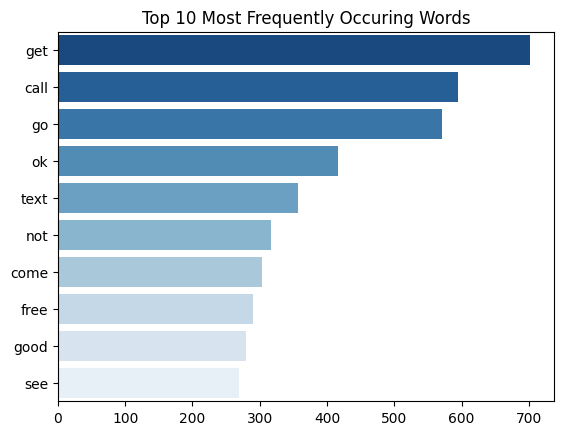

In [ ]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words, hue=words, palette="Blues_r")
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

# (3.2) N_gram

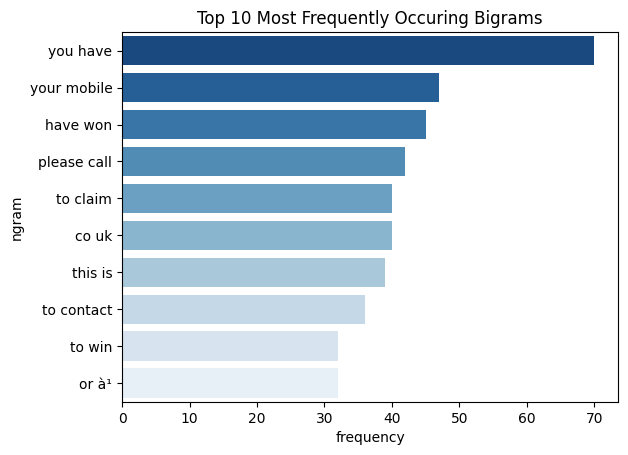

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data[data['target'] == 'spam']['text'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10], palette="Blues_r")
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

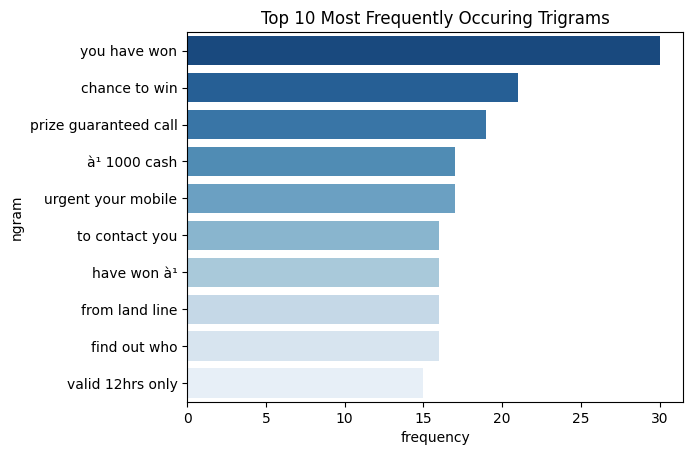

In [ ]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(data[data['target'] == 'spam']['text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue = ngram_freq['ngram'][:10], palette="Blues_r")
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

# (4.) count specific information


In [ ]:
sms = data[['target','text']]
sms.head()

,target,text
0,ham,"Go until jurong point, crazy. Available only i..."
1,ham,Ok lar. Joking wif u oni.
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor. U c already then say.
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 4.1 website

In [ ]:
sms['web'] = sms['text'].apply(lambda x : 1 if re.search('https?://\S+|www\.\S+|cutt\.ly\S+|bit\.ly]\S+', x) else 0)

sms.groupby('target')['web'].value_counts()

target  web
ham     0      4508
        1         1
spam    0       656
        1       119
Name: web, dtype: int64

In [ ]:
sms[(sms['target'] == 'spam') & (sms['web'] == 1)]

,target,text,web
12,spam,URGENT! You have won a 1 week FREE membership ...,1
15,spam,"XXXMobileMovieClub: To use your credit, click ...",1
161,spam,-PLS STOP bootydelious (32/F) is inviting you ...,1
188,spam,Are you unique enough? Find out from 30th Augu...,1
220,spam,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA...",1
...,...,...,...
5274,spam,"Congratulations, received quota 130,000, click...",1
5275,spam,"D Condo Than Resort Condo, ready to move in, n...",1
5278,spam,You've won the prize. You can receive 1000 bah...,1
5279,spam,"Special only for True Red customers, discount ...",1


## 4.2 telephone/number contact

In [ ]:
sms['contact'] = sms['text'].apply(lambda x : 1 if re.search('\d{5,15}', x) else 0)

sms.groupby('target')['contact'].value_counts()

target  contact
ham     0          4506
        1             3
spam    1           514
        0           261
Name: contact, dtype: int64

In [ ]:
sms[(sms['target'] == 'ham') & (sms['contact'] == 1)]

,target,text,web,contact
258,ham,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0,1
966,ham,Yun ah.the ubi one say if à¸¬_ wan call by tom...,0,1
3881,ham,Leave it wif me lar. à¸¬à¸¯ wan to carry meh s...,0,1


In [ ]:
sms[(sms['target'] == 'spam') & (sms['contact'] == 1)]

,target,text,web,contact
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
8,spam,WINNER!! As a valued network customer you have...,0,1
9,spam,Had your mobile 11 months or more? U R entitle...,0,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",0,1
12,spam,URGENT! You have won a 1 week FREE membership ...,1,1
...,...,...,...,...
5220,spam,Come enjoy the hit song number 8803445668. Get...,0,1
5258,spam,"Slot game, share, receive free 79999 baht. Fir...",0,1
5272,spam,Loans to fight through COVID Easy monthly inst...,0,1
5281,spam,"For True customers, great value, just 28 baht,...",0,1


In [ ]:
sms['contact_4'] = sms['text'].apply(lambda x : 1 if re.search('\d{4}', x) else 0)

sms[(sms['target'] == 'spam') & (sms['contact_4'] == 1)]
# 478,660,797,1192,1620,1731,1810,3628,3649,3795,3884,3936,3969,4017,4070,4270,4765,4827,5049,5069,5132,
# 5168,5169,5172,5179,5185-5187,5196,5206,5219,5222,5253,5258,5267,5277-5281,5283

,target,text,web,contact,contact_4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,1,1
8,spam,WINNER!! As a valued network customer you have...,0,1,1
9,spam,Had your mobile 11 months or more? U R entitle...,0,1,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",0,1,1
12,spam,URGENT! You have won a 1 week FREE membership ...,1,1,1
...,...,...,...,...,...
5278,spam,You've won the prize. You can receive 1000 bah...,1,0,1
5279,spam,"Special only for True Red customers, discount ...",1,0,1
5280,spam,Free home internet speed upgrade every month! ...,1,0,1
5281,spam,"For True customers, great value, just 28 baht,...",0,1,1
